### Resumo

Este trabalho tem como objetivo desenvolver modelos de previsão de preços de criptomoedas, com foco na utilização de algoritmos de aprendizado de máquina. Serão implementadas e comparadas duas abordagens principais: uma rede neural recorrente do tipo LSTM (Long Short-Term Memory) e o algoritmo XGBoost (Extreme Gradient Boosting).

A pesquisa envolve o pré-processamento de dados, modelagem, ajuste de hiperparâmetros e avaliação de desempenho por meio de métricas estatísticas, como MAE, RMSE, MAPE e R². Os modelos serão utilizados para prever o preço da criptomoeda para o dia seguinte e para um horizonte de 30 dias à frente, permitindo analisar sua capacidade de generalização e precisão em diferentes prazos de previsão.

### 1. Introdução

Nesta seção é apresentada a motivação do estudo, o contexto do mercado de criptomoedas e a relevância da previsão de preços neste cenário.  
Também são descritos os objetivos gerais e específicos do trabalho, bem como a metodologia adotada.  

### 2. Fundamentação Teórica

Aqui são abordados os conceitos principais que sustentam o trabalho:

- Séries temporais e suas características

- Conceitos de aprendizado de máquina e redes neurais

- Estrutura e funcionamento das redes LSTM

- Algoritmo XGBoost e sua aplicação em previsão

### 3. Metodologia

Esta seção descreve as etapas do desenvolvimento do modelo, desde a obtenção e preparação dos dados até a avaliação dos resultados.


#### 3.1 Importação das Bibliotecas

In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from scikeras.wrappers import KerasRegressor

from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.metrics import RootMeanSquaredError

#### 3.2 Carregamento e Ajuste dos Dados
Os dados foram coletados do yahoo finance em um periodo diário, os dados possuem as variaveis 'Close', 'High', 'Low', 'Open', 'Volume', 'Price'.<br>
Foi realizado ajuste no tipo dos dados e verificação de valores nulos ou duplicados.

In [17]:
data = pd.read_csv('./data/raw/BTC-USD.csv')
data = data.iloc[2:,:]
data.head(5)

,Price,Close,High,Low,Open,Volume
2,2014-09-17,457.3340148925781,468.17401123046875,452.4219970703125,465.864013671875,21056800
3,2014-09-18,424.44000244140625,456.8599853515625,413.10400390625,456.8599853515625,34483200
4,2014-09-19,394.7959899902344,427.8349914550781,384.5320129394531,424.1029968261719,37919700
5,2014-09-20,408.90399169921875,423.2959899902344,389.88299560546875,394.6730041503906,36863600
6,2014-09-21,398.8210144042969,412.4259948730469,393.1809997558594,408.0849914550781,26580100


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4038 entries, 2 to 4039
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Price   4038 non-null   object
 1   Close   4038 non-null   object
 2   High    4038 non-null   object
 3   Low     4038 non-null   object
 4   Open    4038 non-null   object
 5   Volume  4038 non-null   object
dtypes: object(6)
memory usage: 189.4+ KB


In [19]:
cols = ['Close', 'High', 'Low', 'Open', 'Volume']
data[cols] = data[cols].apply(pd.to_numeric, errors='coerce')
data.dtypes

Price      object
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

Apliquei a função pd.to_numeric em cada uma dessas colunas que converte os valores pra número (float ou int)<br>
Se algum valor não puder ser convertido (por exemplo, "ABC", "?", "-"), o parâmetro errors='coerce' manda ele transformar em NaN (valor nulo)

In [20]:
data = data.rename(columns={'Price': 'Date'})
data['Date'] = pd.to_datetime(data['Date'])
data.dtypes

Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object

In [21]:
data = data.set_index('Date')
data = data.sort_index()
data.head(5)


,Close,High,Low,Open,Volume
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


Agora já ajustei o nome da coluna, transformei para data, coloquei a data como indice do meu dataset e ordenei por garantia, porque vi que a ordem era importante para uma LSTM

In [22]:
data.isna().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [23]:
data[data.duplicated() == True]

,Close,High,Low,Open,Volume
Date,,,,,


#### 3.3 Explorando Dados
Nessa seção buscamos apenas entender um pouco melhor os dados.

In [24]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,4038.0,2.532783e+04,3.016165e+04,1.781030e+02,2.518585e+03,1.035051e+04,3.976725e+04,1.252345e+05
High,4038.0,2.581646e+04,3.065215e+04,2.117310e+02,2.597245e+03,1.057803e+04,4.076179e+04,1.260692e+05
Low,4038.0,2.476040e+04,2.958874e+04,1.715100e+02,2.451235e+03,1.011763e+04,3.873628e+04,1.231996e+05
Open,4038.0,2.529802e+04,3.012409e+04,1.768970e+02,2.521515e+03,1.034699e+04,3.974307e+04,1.235020e+05
Volume,4038.0,2.074734e+10,2.196870e+10,5.914570e+06,1.116930e+09,1.661040e+10,3.232521e+10,3.509679e+11


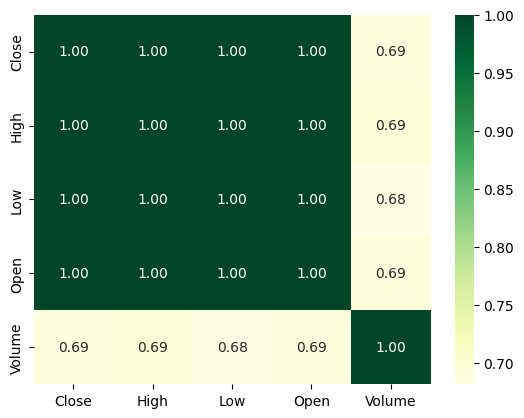

In [25]:
plt.Figure()
sns.heatmap(data.corr(), annot=True, cmap="YlGn", fmt=".2f")
plt.show()

In [26]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)
data_scaled = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

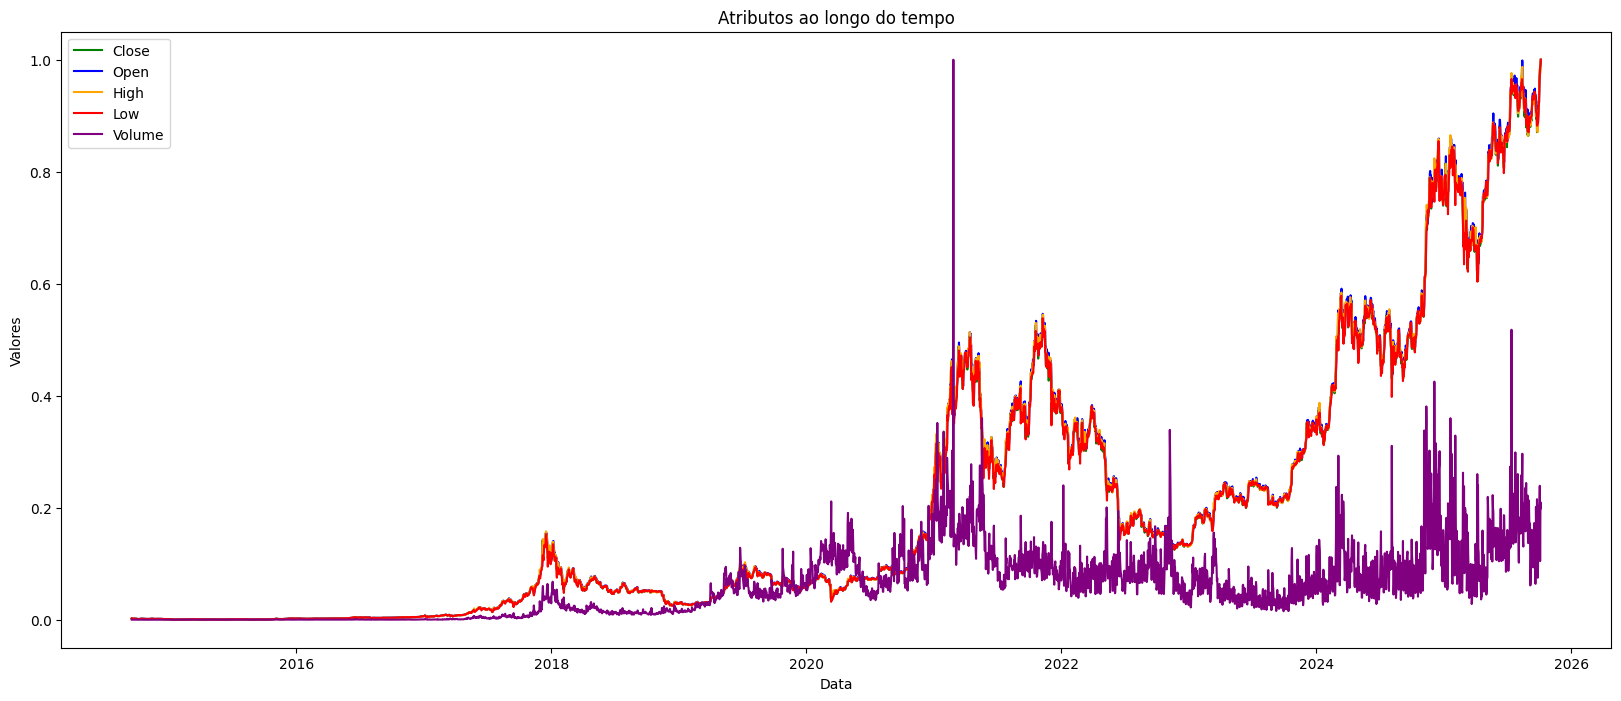

In [27]:
plt.figure(figsize=(20,8))

plt.plot(data_scaled.index, data_scaled['Close'], label='Close', color='green')
plt.plot(data_scaled.index, data_scaled['Open'], label='Open', color='blue')
plt.plot(data_scaled.index, data_scaled['High'], label='High', color='orange')
plt.plot(data_scaled.index, data_scaled['Low'], label='Low', color='red')
plt.plot(data_scaled.index, data_scaled['Volume'], label='Volume', color='purple')

plt.title('Atributos ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()

podemos notar que close, open, high e low possuem praticamente a mesma tendencia como acusado pela matriz de correlação, já o volume tem o comportamento diferente, com picos e quedas meio bruscas

#### 3.4 Predição Dia Seguinte

In [28]:
def create_sequences_uni(data=[], seq_len=7):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

In [29]:
def create_sequences_mult(X, y, seq_len=14):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])   
        ys.append(y[i+seq_len])    
    return np.array(Xs), np.array(ys)

In [30]:
serie_uni = data['Close']

train_size = int(0.8 * len(serie_uni))
train_data_uni = serie_uni[:train_size].values.reshape(-1, 1)
test_data_uni = serie_uni[train_size:].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0,1))
data_uni_train_scaled = scaler.fit_transform(train_data_uni)
data_uni_test_scaled = scaler.transform(test_data_uni)

In [31]:
X_mult = data[['High', 'Low', 'Open', 'Volume']]
y_mult = data[['Close']]

scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

X_mult_scaled = scaler_X.fit_transform(X_mult)
y_mult_scaled = scaler_y.fit_transform(y_mult)

In [32]:
models_lstm = []
models_xgb = []
# seq_len_options = [7, 14, 30]
# split_options = [5, 10]
seq_len_options = [7,14]
split_options = [5]

##### 3.4.1 LSTM (Long Short Term Memory)

In [33]:
def create_lstm_model(seq_len=14, n_features=1, neurons=100, drop=0.2, optimizer='Adam'):
  model = Sequential([
      Input(shape=(seq_len, n_features)),
      LSTM(neurons, return_sequences=True),
      Dropout(drop),
      LSTM((neurons//2), return_sequences=False),
      Dropout(drop),
      Dense(1),
  ])
  model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
  return model


param_grid = {
                # 'model__neurons': [16, 32, 64, 128],
                # 'model__drop': [0.05, 0.1, 0.2],
                # 'model__optimizer': ['Adam'], 
                # 'fit__batch_size': [16, 32, 64],   
                # 'fit__epochs': [50, 100],
                'model__neurons': [32],
                'model__drop': [0.05],
                'model__optimizer': ['Adam'], 
                'fit__batch_size': [16],   
                'fit__epochs': [50],
              }

###### 3.4.1.1 Modelo Univariado

In [34]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_train_scaled, y_train_scaled = create_sequences_uni(data_uni_train_scaled, seq_len)
  X_test_scaled, y_test_scaled = create_sequences_uni(data_uni_test_scaled, seq_len)

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

    grid_result = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm.append({
      "params": grid_result.best_params_,
      "rmse": -grid_result.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "type": "Univariado",
      "algorithm": "LSTM"
    })
    
    print(f"Menor RMSE: {-grid_result.best_score_:.3f} usando: {grid_result.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.021 usando: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.05, 'model__neurons': 32, 'model__optimizer': 'Adam'}
===== JANELA DE 14 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.026 usando: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.05, 'model__neurons': 32, 'model__optimizer': 'Adam'}


###### 3.4.1.2 Modelo Multivariado

In [35]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_seq, y_seq = create_sequences_mult(X_mult_scaled, y_mult_scaled, seq_len)

  train_size = int(0.8 * len(X_seq))

  X_train_scaled, X_test_scaled = X_seq[:train_size], X_seq[train_size:]
  y_train_scaled, y_test_scaled = y_seq[:train_size], y_seq[train_size:]

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

    grid_result = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm.append({
      "params": grid_result.best_params_,
      "rmse": -grid_result.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "type": "Multivariado",
      "algorithm": "LSTM"
    })
    
    print(f"Menor RMSE: {-grid_result.best_score_:.3f} usando: {grid_result.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.012 usando: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.05, 'model__neurons': 32, 'model__optimizer': 'Adam'}
===== JANELA DE 14 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.012 usando: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.05, 'model__neurons': 32, 'model__optimizer': 'Adam'}


###### 3.4.1.3 Resultados e Discussão

Nesta seção são apresentados e discutidos os resultados obtidos pelos modelos.
Comente sobre o desempenho de cada configuração de parâmetros e interprete as métricas.  
Apresente também comparações gráficas entre valores reais e previstos.


In [36]:
ordered_models = sorted(models_lstm, key=lambda x: x["rmse"])
ordered_models

[{'params': {'fit__batch_size': 16,
   'fit__epochs': 50,
   'model__drop': 0.05,
   'model__neurons': 32,
   'model__optimizer': 'Adam'},
  'rmse': np.float64(0.012480637814214983),
  'n_splits': 5,
  'seq_len': 7,
  'type': 'Multivariado',
  'algorithm': 'LSTM'},
 {'params': {'fit__batch_size': 16,
   'fit__epochs': 50,
   'model__drop': 0.05,
   'model__neurons': 32,
   'model__optimizer': 'Adam'},
  'rmse': np.float64(0.012487443546095073),
  'n_splits': 5,
  'seq_len': 14,
  'type': 'Multivariado',
  'algorithm': 'LSTM'},
 {'params': {'fit__batch_size': 16,
   'fit__epochs': 50,
   'model__drop': 0.05,
   'model__neurons': 32,
   'model__optimizer': 'Adam'},
  'rmse': np.float64(0.02131636408643515),
  'n_splits': 5,
  'seq_len': 7,
  'type': 'Univariado',
  'algorithm': 'LSTM'},
 {'params': {'fit__batch_size': 16,
   'fit__epochs': 50,
   'model__drop': 0.05,
   'model__neurons': 32,
   'model__optimizer': 'Adam'},
  'rmse': np.float64(0.025981646230009363),
  'n_splits': 5,
  's

In [37]:
grid_result.best_estimator_

,model,<function cre...002AB4D75F740>
,build_fn,None
,warm_start,False
,random_state,None
,optimizer,'rmsprop'
,loss,None
,metrics,None
,batch_size,None
,validation_batch_size,None
,verbose,0
,callbacks,None


In [38]:
y_pred_scaled = grid_result.best_estimator_.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled))
mae = mean_absolute_error(y_test_scaled, y_pred_scaled)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)


MAE: 0.04155988064026369
RMSE: 0.05905000009677942


In [39]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

mae_percent = (mae / len(y_test)) * 100
rmse_percent = (rmse / len(y_test)) * 100
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAE(%): {mae_percent:.2f}%")
print(f"RMSE(%): {rmse_percent:.2f}%")
print(f"MAPE(%): {mape:.2f}%")

MAE: 5197.328362771739
RMSE: 7384.579815221902
MAE(%): 645.63%
RMSE(%): 917.34%
MAPE(%): 5.74%


In [40]:
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.2f}")


R²: 0.93


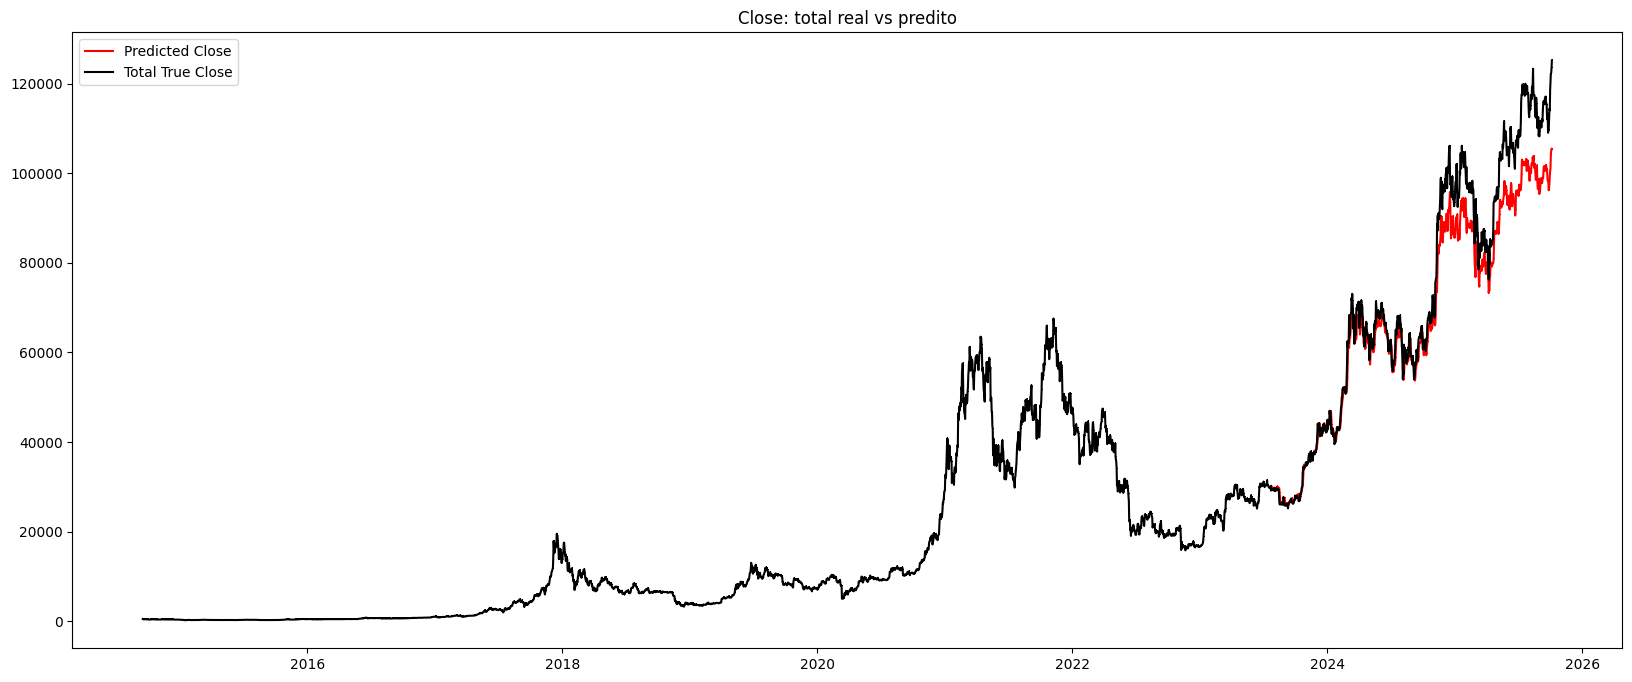

In [41]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

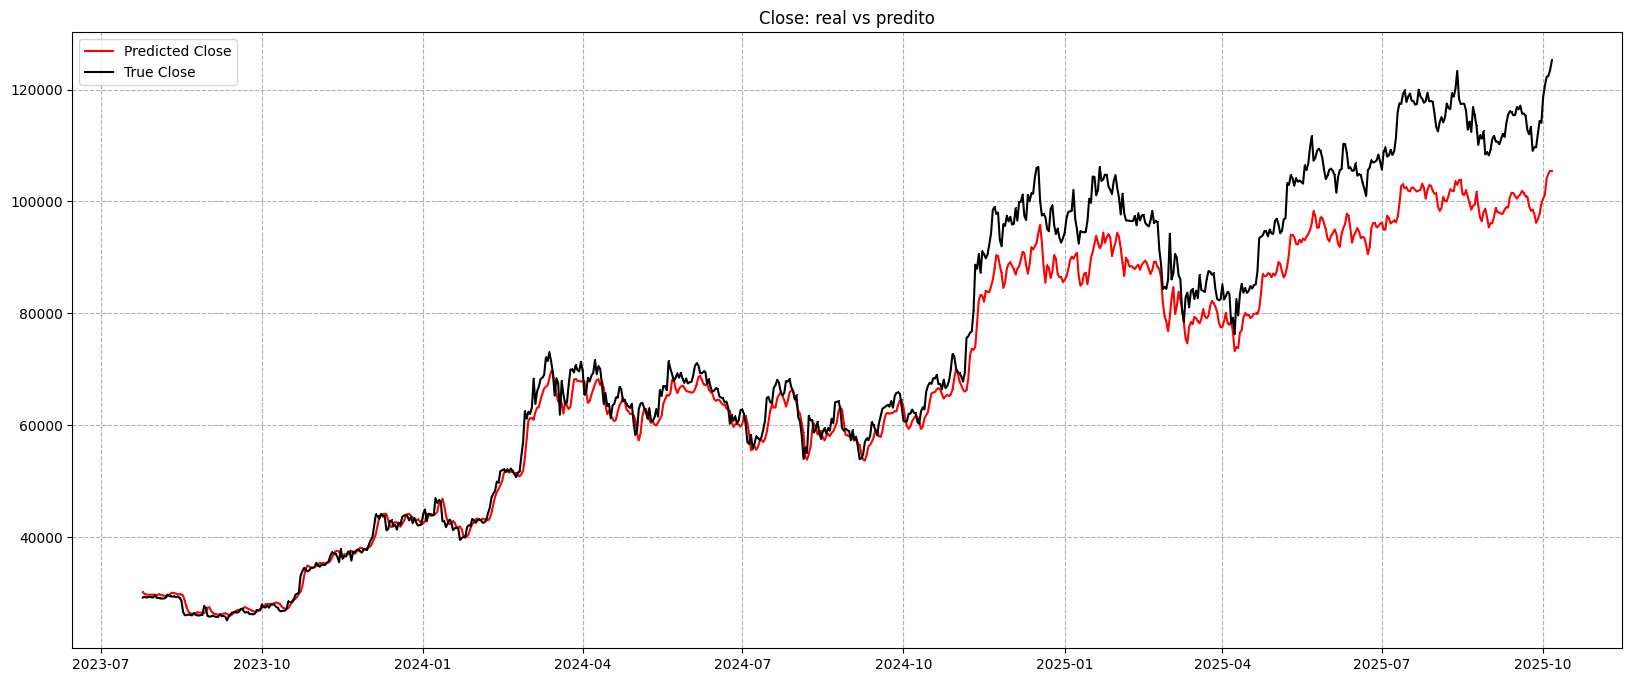

In [42]:
dias_analise=30

plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
# plt.plot(data.index[-dias_analise:], y_pred[-dias_analise:], color="red", marker=",", label='Predicted Close')
# plt.plot(data.index[-dias_analise:], y_test[-dias_analise:], color="black", marker=",", label='True Close')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()

##### 3.4.2 XGB (XGBoost)

In [43]:
param_grid = {
    'n_estimators': [60, 100],           
    'learning_rate': [0.1, 0.15, 0.2, 0.25],        
    'max_depth': [3, 5],   
    'subsample': [0.95, 0.90, 0.80],        
    'colsample_bytree': [0.95, 0.90, 0.80], 
}

###### 3.4.2.1 Modelo Univariado

In [44]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_train_scaled, y_train_scaled = create_sequences_uni(data_uni_train_scaled, seq_len)
  X_test_scaled, y_test_scaled = create_sequences_uni(data_uni_test_scaled, seq_len)

  n_samples_train = X_train_scaled.shape[0]
  X_train_flat = X_train_scaled.reshape(n_samples_train, -1)


  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, eval_metric='rmse')

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1, refit=True)

    grid_result = grid.fit(X_train_flat, y_train_scaled)

    models_xgb.append({
      "params": grid_result.best_params_,
      "rmse": -grid_result.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "type": "Univariado",
      "algorithm": "XGB"
    })
    
    print(f"Menor RMSE: {-grid_result.best_score_:.3f} usando: {grid_result.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.101 usando: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 60, 'subsample': 0.95}
===== JANELA DE 14 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.106 usando: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 60, 'subsample': 0.9}


###### 3.4.2.2 Modelo Multivariado

In [45]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_seq, y_seq = create_sequences_mult(X_mult_scaled, y_mult_scaled, seq_len)

  train_size = int(0.8 * len(X_seq))

  X_train_scaled, X_test_scaled = X_seq[:train_size], X_seq[train_size:]
  y_train_scaled, y_test_scaled = y_seq[:train_size], y_seq[train_size:]
  
  n_samples_train = X_train_scaled.shape[0]
  X_train_flat = X_train_scaled.reshape(n_samples_train, -1)

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, eval_metric='rmse')

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1, refit=True)

    grid_result = grid.fit(X_train_flat, y_train_scaled)

    models_xgb.append({
      "params": grid_result.best_params_,
      "rmse": -grid_result.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "type": "Univariado",
      "algorithm": "XGB"
    })
    
    print(f"Menor RMSE: {-grid_result.best_score_:.3f} usando: {grid_result.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.058 usando: {'colsample_bytree': 0.95, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 60, 'subsample': 0.8}
===== JANELA DE 14 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.060 usando: {'colsample_bytree': 0.95, 'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 60, 'subsample': 0.8}


###### 3.4.2.3 Resultados e Discussão

Nesta seção são apresentados e discutidos os resultados obtidos pelos modelos.
Comente sobre o desempenho de cada configuração de parâmetros e interprete as métricas.  
Apresente também comparações gráficas entre valores reais e previstos.


In [46]:
ordered_models = sorted(models_xgb, key=lambda x: x["rmse"])
ordered_models

[{'params': {'colsample_bytree': 0.95,
   'learning_rate': 0.2,
   'max_depth': 3,
   'n_estimators': 60,
   'subsample': 0.8},
  'rmse': np.float64(0.057803255441048015),
  'n_splits': 5,
  'seq_len': 7,
  'type': 'Univariado',
  'algorithm': 'XGB'},
 {'params': {'colsample_bytree': 0.95,
   'learning_rate': 0.15,
   'max_depth': 3,
   'n_estimators': 60,
   'subsample': 0.8},
  'rmse': np.float64(0.059532037234689084),
  'n_splits': 5,
  'seq_len': 14,
  'type': 'Univariado',
  'algorithm': 'XGB'},
 {'params': {'colsample_bytree': 0.8,
   'learning_rate': 0.2,
   'max_depth': 5,
   'n_estimators': 60,
   'subsample': 0.95},
  'rmse': np.float64(0.10077392564974326),
  'n_splits': 5,
  'seq_len': 7,
  'type': 'Univariado',
  'algorithm': 'XGB'},
 {'params': {'colsample_bytree': 0.9,
   'learning_rate': 0.1,
   'max_depth': 3,
   'n_estimators': 60,
   'subsample': 0.9},
  'rmse': np.float64(0.10601821919019938),
  'n_splits': 5,
  'seq_len': 14,
  'type': 'Univariado',
  'algorithm': 

In [47]:
grid_result.best_estimator_

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.95
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


In [48]:
n_samples_test = X_test_scaled.shape[0]
X_test_flat = X_test_scaled.reshape(n_samples_test, -1)


y_pred_scaled = grid_result.best_estimator_.predict(X_test_flat)

rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled))
mae = mean_absolute_error(y_test_scaled, y_pred_scaled)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

y_pred_scaled_2d = y_pred_scaled.reshape(-1, 1)
y_test_scaled_2d = y_test_scaled.reshape(-1, 1)

y_pred = scaler_y.inverse_transform(y_pred_scaled_2d)
y_test = scaler_y.inverse_transform(y_test_scaled_2d)

MAE: 0.14071614276513683
RMSE: 0.21156906367341077


In [49]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

mae_percent = (mae / len(y_test)) * 100
rmse_percent = (rmse / len(y_test)) * 100
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAE(%): {mae_percent:.2f}%")
print(f"RMSE(%): {rmse_percent:.2f}%")
print(f"MAPE(%): {mape:.2f}%")

MAE: 17597.453988742236
RMSE: 26458.065587435736
MAE(%): 2186.02%
RMSE(%): 3286.72%
MAPE(%): 17.95%


In [50]:
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.2f}")


R²: 0.13


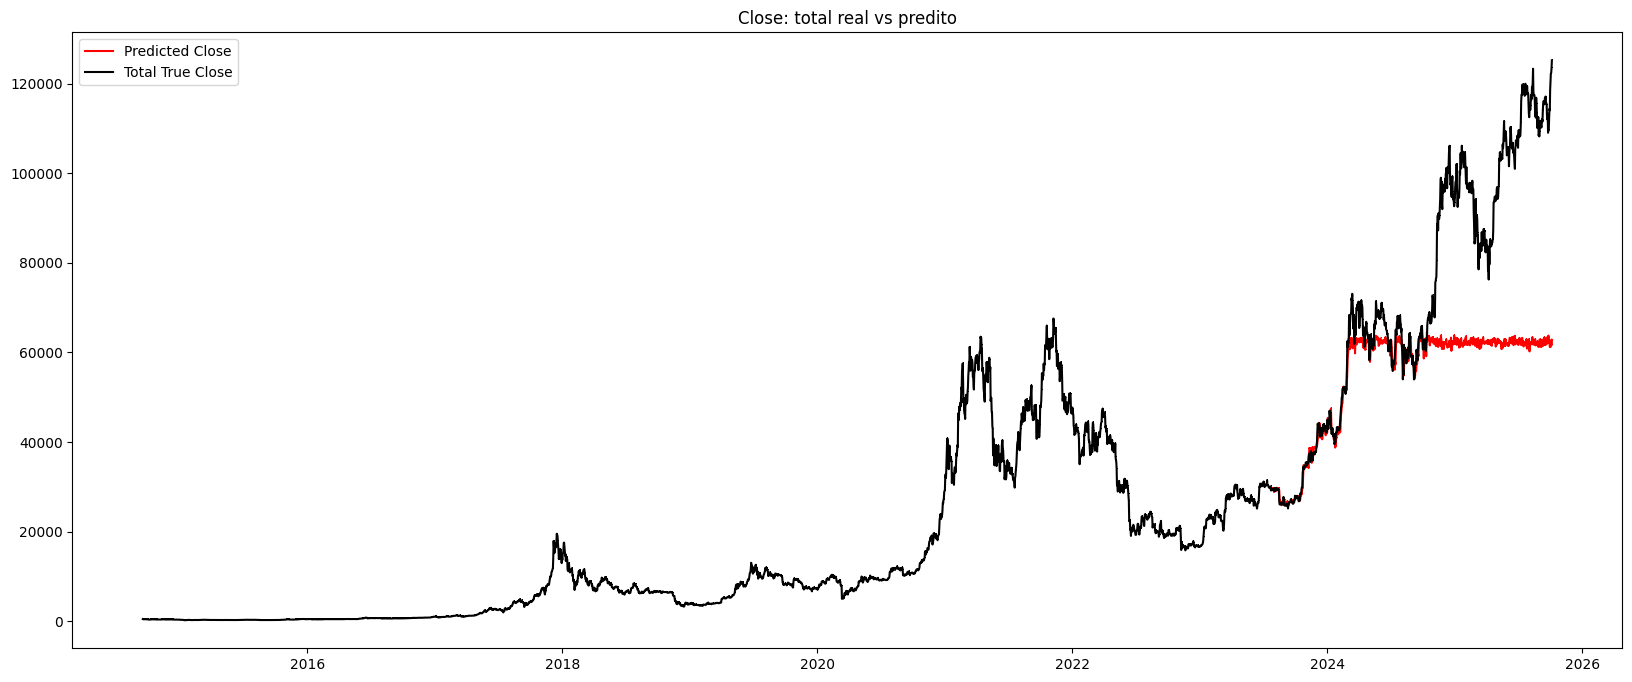

In [51]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

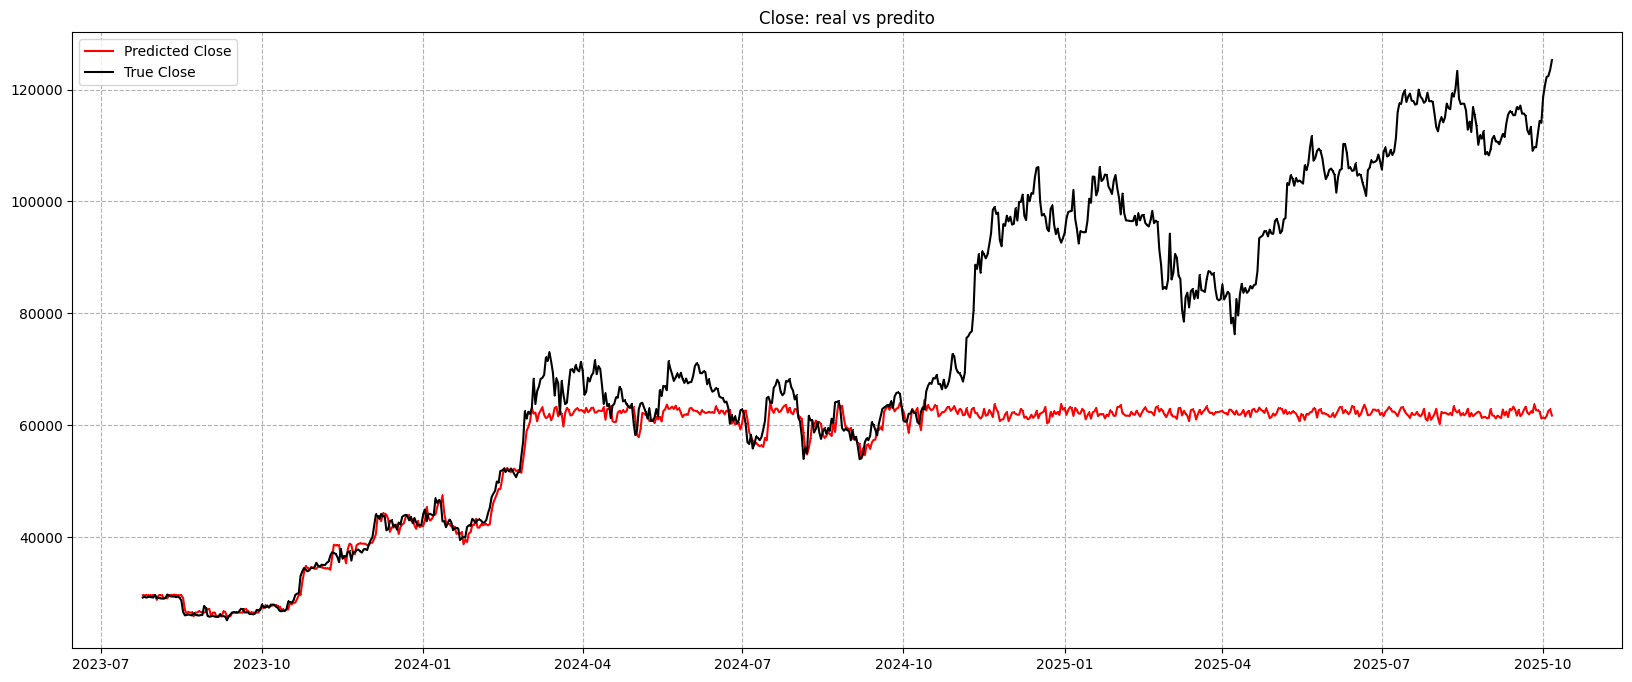

In [52]:
dias_analise=30

plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
# plt.plot(data.index[-dias_analise:], y_pred[-dias_analise:], color="red", marker=",", label='Predicted Close')
# plt.plot(data.index[-dias_analise:], y_test[-dias_analise:], color="black", marker=",", label='True Close')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()